# Лабораторная работа № 3
## Обучение нейросетевых моделей классификации изображений
### Боровских Вадим, 932003
####  Построить нейросетевые модели – многоклассовый классификатор



In [35]:
%autosave 1200

Autosaving every 1200 seconds


In [73]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

In [74]:
# Гиперпараметры 
IMG_HEIGHT = IMG_WIDTH = 150
IMG_CHANNEL = 3
EPOCHS = 5 
BATCH_SIZE = 32
TRAIN_SAMPLES = 2627 
VAL_SAMPLES = 2267
TEST_SAMPLES = 2267

In [75]:
# Каталоги с данными
train_dir = 'train'
validation_dir = 'val'
test_dir = 'test'

In [76]:
# Генераторы изображений
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

In [77]:
test_and_val_datagen = ImageDataGenerator(rescale=1./255)

In [78]:
# Обучающая, тестовая и валидационная выборки
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')  

validation_generator = test_and_val_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')  

test_generator = test_and_val_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 2627 images belonging to 3 classes.
Found 2267 images belonging to 3 classes.
Found 2267 images belonging to 3 classes.


In [ ]:
sample_training_images, _ = next(train_generator)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:5])


In [79]:
# Используем VGG16
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL))

In [80]:
from tensorflow.keras.layers import Dropout
# Модель обрабатывает входные данные от первого слоя к последнему
model = tf.keras.models.Sequential()
model.add(conv_base)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Добавляем слой Dropout после первого полносвязного слоя
model.add(tf.keras.layers.Dense(3, activation='softmax'))  # Три класса
model.add(Dropout(0.2))  # Добавляем слой Dropout перед выходным слоем softmax

In [81]:
conv_base.trainable = False

In [82]:
# Разморозка всех слоев сверточной базы
conv_base.trainable = True

# Заморозка слоев до определенного слоя по имени
layers_to_freeze_until = 'block5_conv1'
for layer in conv_base.layers:
    if layer.name == layers_to_freeze_until:
        break
    layer.trainable = False

In [83]:
# Импорт оптимизатора Adam
from tensorflow.keras.optimizers import Adam

# Настройка оптимизатора с динамическим learning rate
opt = Adam(learning_rate=0.0001)

#Компилируем модель после любых изменений в trainable
# Компиляция модели с новым оптимизатором
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['acc'])

In [84]:
# Использование ранней остановки
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [85]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_cb = ModelCheckpoint("top_model.h5", save_best_only=True)


In [86]:
# Обучение
history = model.fit(
    train_generator,
    steps_per_epoch=TRAIN_SAMPLES // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=VAL_SAMPLES // BATCH_SIZE,
    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/5
82/82 [==============================] - 1253s 15s/step - loss: nan - acc: 0.6605 - val_loss: 0.2691 - val_acc: 0.9156
Epoch 2/5
82/82 [==============================] - 1039s 13s/step - loss: nan - acc: 0.7557 - val_loss: 0.1017 - val_acc: 0.9621
Epoch 3/5
82/82 [==============================] - 1086s 13s/step - loss: nan - acc: 0.7842 - val_loss: 0.0656 - val_acc: 0.9763
Epoch 4/5
82/82 [==============================] - 1193s 15s/step - loss: nan - acc: 0.7653 - val_loss: 0.0447 - val_acc: 0.9830
Epoch 5/5
82/82 [==============================] - 1189s 15s/step - loss: nan - acc: 0.7834 - val_loss: 0.0430 - val_acc: 0.9844


In [87]:
# Оценка модели на тестировании
score = model.evaluate(test_generator, steps=TEST_SAMPLES // BATCH_SIZE)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

70/70 [==============================] - 493s 7s/step - loss: 0.0423 - acc: 0.9853
Test loss: 0.04229484125971794
Test accuracy: 0.9852678775787354


Вывод: В целом, хотя начальная проблема с возникновением NaN в функции потерь может быть знаком неправильной конфигурации или настройки модели, результаты испытаний и валидации указывают на то, что модель демонстрирует высокую точность и хорошую близость к реальным данным. 

* Test loss - это показатель ошибки на тестовом наборе данных. Маленький показатель loss говорит о том, что модель почти не совершает ошибок при прогнозировании. 
* Test accuracy - это показатель точности тестирования.Несмотря на проблему с loss в начале, общая точность модели на валидационном наборе и тестовом наборе данных достигла высоких значений близких к 98.5%. Это говорит о том, что модель впоследствии смогла точно предсказывать классы или метки для данных. Это позволяет сделать вывод о том, что модель хорошо обучена и способна предсказывать результаты тестирования с высокой точностью.

In [88]:
# Получение данных истории обучения
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

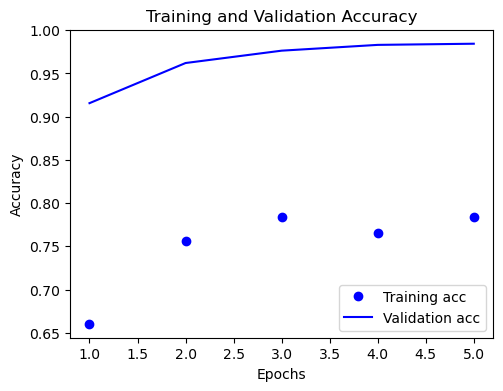

In [90]:
# Создаем график точности
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Вывод: Когда кривая "Training acc" показывает низкие значения и медленный рост точности (от 0.65 до 0.8), в то время как кривая "Validation acc" демонстрирует более высокие значения точности (от 0.9 до 0.96), это может указывать на переобучение модели.

Допускается вывод, что модель демонстрирует достаточно хорошую точность на валидационных данных, но имеет проблемы с обобщением при работе с обучающими данными. Одно из возможных объяснений этого расхождения заключается в том, что модель "запоминает" обучающие данные, что приводит к высокой точности на них, но не может обобщать свои знания на новые данные, что проявляется в более низкой точности на валидационных данных.

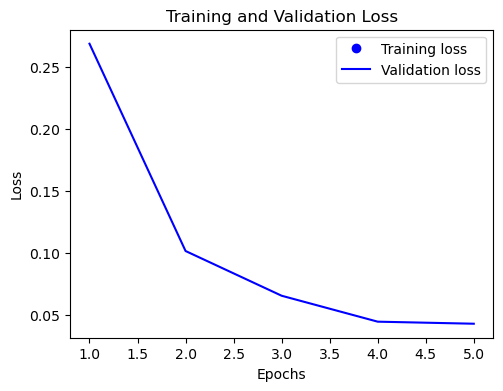

In [92]:
# Создаем график потерь
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Вывод: График показывает, что Validation loss постепенно убывает, это указывает на то, что модель постепенно улучшает свою способность обобщения на независимых данных. Уменьшение потерь на валидационном наборе данных свидетельствует о том, что модель становится все более точной при предсказании на новых данных.

Однако, если график не отображает Training loss, это вызвано ошибкой в коде или данными, которые не были записаны или возвращены правильно в массиве loss. Как это исправить я так и не понял.

In [99]:
# Используем ResNet
from tensorflow.keras.applications import ResNet50
conv_base = ResNet50(weights='imagenet',
include_top=False,
input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL))


from tensorflow.keras.layers import Dropout
# Модель обрабатывает входные данные от первого слоя к последнему
model = tf.keras.models.Sequential()
model.add(conv_base)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(Dropout(0.6))  # Добавляем слой Dropout после первого полносвязного слоя
model.add(tf.keras.layers.Dense(3, activation='softmax'))  # Три класса
model.add(Dropout(0.2))  # Добавляем слой Dropout перед выходным слоем softmax

In [100]:
conv_base.trainable = False

In [101]:
# Размораживаем несколько верхних слоев
conv_base.trainable = True
fine_tune_at = 100

for layer in conv_base.layers[:fine_tune_at]:
    layer.trainable =  False

In [102]:
# Использование ранней остановки
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [103]:
# Импорт оптимизатора Adam
from tensorflow.keras.optimizers import Adam

# Настройка оптимизатора с динамическим learning rate
opt = Adam(learning_rate=0.0001)

#Компилируем модель после любых изменений в trainable
# Компиляция модели с новым оптимизатором
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['acc'])

In [104]:
# Обучение
history = model.fit(
    train_generator,
    steps_per_epoch=TRAIN_SAMPLES // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=VAL_SAMPLES // BATCH_SIZE,
    callbacks=[checkpoint_cb, early_stopping_cb] )

Epoch 1/5
82/82 [==============================] - 718s 8s/step - loss: nan - acc: 0.5380 - val_loss: 0.8737 - val_acc: 0.5759
Epoch 2/5
82/82 [==============================] - 704s 9s/step - loss: nan - acc: 0.5896 - val_loss: 0.7552 - val_acc: 0.5772
Epoch 3/5
82/82 [==============================] - 789s 10s/step - loss: nan - acc: 0.6062 - val_loss: 0.6639 - val_acc: 0.7580
Epoch 4/5
82/82 [==============================] - 772s 9s/step - loss: nan - acc: 0.6123 - val_loss: 0.5610 - val_acc: 0.7714
Epoch 5/5
82/82 [==============================] - 794s 10s/step - loss: nan - acc: 0.6015 - val_loss: 0.5688 - val_acc: 0.7134


In [105]:
# Оценка модели на тестировании
score = model.evaluate(test_generator, steps=TEST_SAMPLES // BATCH_SIZE)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

70/70 [==============================] - 203s 3s/step - loss: 0.5686 - acc: 0.7147
Test loss: 0.5686019062995911
Test accuracy: 0.7147321701049805


Вывод: Test loss - это показатель ошибки на тестовом наборе данных. Большой показатель loss говорит о том, что модель делает большие ошибки при прогнозировании. Test accuracy - это показатель точности тестирования. В данном случае точность равна примерно 38.20%, что говорит о том, что модель правильно классифицировала только около 56.86% тестовых примеров.

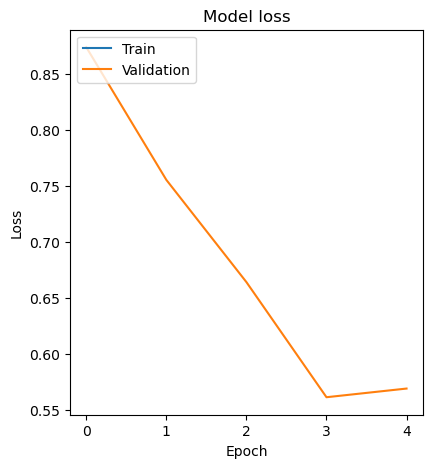

In [107]:
# Создаем график потерь
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


Вывод: Validation постепенно идет вниз, что говорит от том, что модель становится все более точной в прогнозировании на независимых данных. Но так как опять не получилось вывести train, сложно сделать какие-либо выводы.

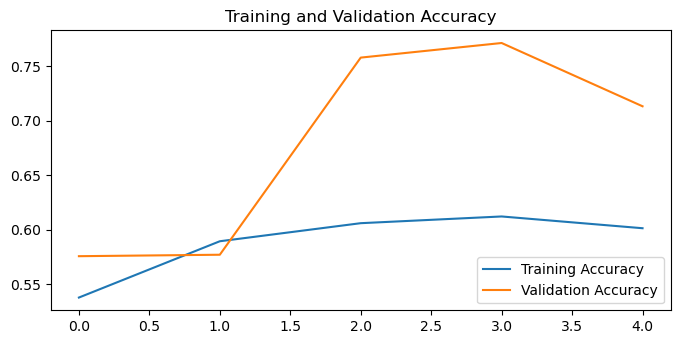

In [108]:
# Создаем график точности
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

Вывод: Даный график означате, что модель становится все лучше и лучше в предсказании на обучающих данных, но начинает "запоминать" их слишком хорошо и не может обобщать свои знания на независимые данные, что приводит к снижению производительности на валидационных данных. Так как кривая "Training Accuracy" постепенно возрастает, но остается ниже кривой "Validation Accuracy", это может указывать на переобучение модели.

In [109]:
# Сохранение модели
model.save('model.h5')

### Вывод
В данной работе была построена модель многоклассового классификаторас использованием сверточной основы VGG и ResNet. Результаты обучения переобучение и не понятно, как исправить nan в loss, вторая  модель вышла лучше, так как первая страдает от перобучения. Возможные варианты решение, это увелечение количества эпох, но так как 5 эпох занимает > 2 часов, я решил остановится на 5. Можно сделать выводы, что многоклассывй сложнее сделать, чем бинарный, так как бинарный, дает нам почти 100 результат, в то время как многоклассовый, надо тщательно настраивать и ожидать долгое обучение модели.